<a href="https://colab.research.google.com/github/Haebuk/dataminingTP/blob/main/TermProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 아파트 실거래가 예측

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from tqdm.notebook import tqdm
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
import re
from gensim.models.word2vec import Word2Vec
!pip install konlpy -q
from konlpy.tag import Okt

import matplotlib as mpl  # 기본 설정 만지는 용도
import matplotlib.pyplot as plt  # 그래프 그리는 용도
import matplotlib.font_manager as fm
!apt-get update -qq
!apt-get install fonts-nanum* -qq
path = '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf'  # 설치된 나눔글꼴중 원하는 녀석의 전체 경로를 가져오자
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)
fm._rebuild()
mpl.rcParams['axes.unicode_minus'] = False

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


NanumGothic Eco


## Data Load

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
PATH = '/content/drive/MyDrive/input/dataminingTP/'
train_df = pd.read_csv(PATH + 'train_df_regex.csv')
test_df = pd.read_csv(PATH + 'test_df_regex.csv')
o_train_df = pd.read_csv(PATH + 'train.csv')

- exclusive_use_area: 전용면적(한 세대만 독점적으로 사용하는 공간)
- transaction_real_price: 실거래가(단위:만원, 타겟 값, train만 존재)
- transaction_year_month: 거래년월
- transaction_date: 거래일
- floor: 층 

- 데이터가 거래시간 순으로 이루어져 있음

### regex preprocessing
- apt 이름에 존재하는 괄호 + 괄호안 내용 제거

In [ ]:
# 괄호와 괄호안내용 제거
#regex = "\(.*\)|\s-\s.*"
#for i in tqdm(range(len(train_df)), position=0, leave=True):
#    train_df['apt'][i] = re.sub(regex, '', train_df['apt'][i])

#train_df.to_csv('train_df_regex.csv', index=False)


In [ ]:
# 괄호와 괄호안내용 제거
#regex = "\(.*\)|\s-\s.*"
#for j in tqdm(range(len(test_df)),position=0, leave=True):
#    test_df['apt'][i] = re.sub(regex, '', test_df['apt'][i])
    
#test_df.to_csv('test_df_regex.csv', index=False)

## Preprocessing
### Train and Test set

In [ ]:
train_df.describe() 

,transaction_id,apartment_id,exclusive_use_area,year_of_completion,transaction_year_month,floor,transaction_real_price
count,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06
mean,6.091530e+05,6.299685e+03,7.816549e+01,1.998297e+03,2.012984e+05,9.343291e+00,3.822769e+04
std,3.526198e+05,3.581169e+03,2.915113e+01,8.941347e+00,2.905732e+02,6.606500e+00,3.104898e+04
min,0.000000e+00,0.000000e+00,9.260000e+00,1.961000e+03,2.008010e+05,-4.000000e+00,1.000000e+02
25%,3.041380e+05,3.345000e+03,5.976000e+01,1.993000e+03,2.010100e+05,4.000000e+00,1.900000e+04
50%,6.082760e+05,5.964000e+03,8.241000e+01,1.999000e+03,2.013120e+05,8.000000e+00,3.090000e+04
75%,9.124140e+05,9.436000e+03,8.497000e+01,2.005000e+03,2.015110e+05,1.300000e+01,4.700000e+04
max,1.234827e+06,1.265800e+04,4.243200e+02,2.017000e+03,2.017110e+05,8.000000e+01,8.200000e+05


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1216553 entries, 0 to 1216552
Data columns (total 13 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   transaction_id          1216553 non-null  int64  
 1   apartment_id            1216553 non-null  int64  
 2   city                    1216553 non-null  object 
 3   dong                    1216553 non-null  object 
 4   jibun                   1216553 non-null  object 
 5   apt                     1215092 non-null  object 
 6   addr_kr                 1216553 non-null  object 
 7   exclusive_use_area      1216553 non-null  float64
 8   year_of_completion      1216553 non-null  int64  
 9   transaction_year_month  1216553 non-null  int64  
 10  transaction_date        1216553 non-null  object 
 11  floor                   1216553 non-null  int64  
 12  transaction_real_price  1216553 non-null  int64  
dtypes: float64(1), int64(6), object(6)
memory usage: 120.7+ M

- train_df 결측치는 없음
- 1961년 ~ 2017년 완공 건물
- 9.26m^2 ~ 424.32m^2 전용면적
- Floor의 경우 음의 값 존재.
- 실거래가는 100만원부터 820억까지 존재

In [ ]:
train_df.loc[train_df['transaction_real_price']==820000]

,transaction_id,apartment_id,city,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor,transaction_real_price
23603,23603,11320,서울특별시,한남동,810,한남더힐,한남동 810 한남더힐,244.749,2011,201612,21~31,3,820000


In [ ]:
test_df.describe()

,transaction_id,apartment_id,exclusive_use_area,year_of_completion,transaction_year_month,floor
count,5.463000e+03,5463.000000,5463.000000,5463.000000,5463.000000,5463.000000
mean,1.167126e+06,6287.570932,79.495250,2000.431082,201710.228446,8.266886
std,4.075365e+04,3624.756304,32.935434,9.982040,2.798195,6.082475
min,1.092791e+06,12.000000,10.321500,1961.000000,201701.000000,-1.000000
25%,1.134296e+06,3278.000000,59.760000,1995.000000,201709.000000,4.000000
50%,1.167937e+06,6091.000000,81.720000,2002.000000,201712.000000,7.000000
75%,1.202560e+06,9416.500000,84.970000,2007.000000,201712.000000,11.000000
max,1.234930e+06,12652.000000,273.860000,2017.000000,201712.000000,55.000000


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5463 entries, 0 to 5462
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   transaction_id          5463 non-null   int64  
 1   apartment_id            5463 non-null   int64  
 2   city                    5463 non-null   object 
 3   dong                    5463 non-null   object 
 4   jibun                   5463 non-null   object 
 5   apt                     5463 non-null   object 
 6   addr_kr                 5463 non-null   object 
 7   exclusive_use_area      5463 non-null   float64
 8   year_of_completion      5463 non-null   int64  
 9   transaction_year_month  5463 non-null   int64  
 10  transaction_date        5463 non-null   object 
 11  floor                   5463 non-null   int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 512.3+ KB


### apart

In [ ]:
train_df['apt'].value_counts()

현대         17716
한신         10135
삼성          6771
대우          6390
신동아         6386
           ...  
현진타워           1
도올탑스텔          1
체리빌            1
연세7차 B동        1
세경더빌           1
Name: apt, Length: 9373, dtype: int64

In [ ]:
# 같은 아파트 이름을 같는 수를 저장하는 apt_counts 열 생성
train_df['apt_counts'] = 0
train_df.groupby('apt')['apt_counts'].count()
train_df = pd.merge(train_df, train_df.groupby('apt')['apt_counts'].count(), on='apt', how='left').drop('apt_counts_x', axis=1).rename(columns={'apt_counts_y':'apt_counts'})

test_df['apt_counts'] = 0
test_df.groupby('apt')['apt_counts'].count()
test_df = pd.merge(test_df, test_df.groupby('apt')['apt_counts'].count(), on='apt', how='left').drop('apt_counts_x', axis=1).rename(columns={'apt_counts_y':'apt_counts'})

train_df.head(3)

,transaction_id,apartment_id,city,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor,transaction_real_price,apt_counts
0,0,7622,서울특별시,신교동,6-13,신현,신교동 6-13 신현(101동),84.82,2002,200801,21~31,2,37500,13.0
1,1,5399,서울특별시,필운동,142,사직파크맨션,필운동 142 사직파크맨션,99.17,1973,200801,1~10,6,20000,1.0
2,2,3578,서울특별시,필운동,174-1,두레엘리시안,필운동 174-1 두레엘리시안,84.74,2007,200801,1~10,6,38500,13.0


In [ ]:
train_df.shape

(1216553, 14)

In [ ]:
train_df['apt'].value_counts()[:10]

현대       17716
한신       10135
삼성        6771
대우        6390
신동아       6386
두산        5801
우성        5781
주공2       5669
삼성래미안     5483
벽산        4651
Name: apt, dtype: int64

- top10 시공사 + 데이터에서 가장 많이 나오는 아파트 20개의 이름을 통일

In [4]:
train_df['top10'] = 0
test_df['top10'] = 0
top10 = ['자이', '푸르지오', '더샵', '롯데캐슬', '이편한|e편한|e-편한',
         '힐스테이트', '아이파크', '래미안', 'sk|SK|에스케이', '데시앙']

train_df['apt'] = train_df['apt'].fillna('others')
for i, brand in enumerate(top10):
    train_df.loc[train_df['apt'].str.contains(brand), 'top10'] = 1
    test_df.loc[test_df['apt'].str.contains(brand), 'top10'] = 1


In [ ]:
apt_names = ['그레이스', '양지', '쌍용', '현대', '한신', '삼성', '대우', '신동아', '두산', '주공',
             '우성', '벽산', '동원로얄듀크','경남', '삼환', '쌍용', '삼익', '대림', '코오롱', '파크리오',
             '엘지', '성원', '잠실', '동궁리치웰', '동성']
apt_names = top10 + apt_names
for a in apt_names:
    train_df.loc[train_df['apt'].str.contains(a), 'apt'] = a
    test_df.loc[test_df['apt'].str.contains(a), 'apt'] = a

#top10에 해당하는 아파트가 아니면서 50채가 안될 경우 others로 변경
train_df.loc[(train_df['top10']==0) & (train_df['apt_counts'] < 50), 'apt'] = 'others'
test_df.loc[(test_df['top10']==0) & (test_df['apt_counts'] < 10), 'apt'] = 'others'

In [ ]:
apt_list_tr = train_df.groupby(['apt'])['apt_counts'].agg('count').reset_index().sort_values('apt_counts', ascending=False).reset_index(drop=True)
apt_list_tr
apt_list_te = test_df.groupby(['apt'])['apt_counts'].agg('count').reset_index().sort_values('apt_counts', ascending=False).reset_index(drop=True)
apt_list_te

,apt,apt_counts
0,others,4377
1,래미안,187
2,이편한|e편한|e-편한,93
3,푸르지오,86
4,롯데캐슬,78
5,힐스테이트,61
6,자이,60
7,현대,46
8,아이파크,46
9,sk|SK|에스케이,37


In [ ]:
apt_list_tr

,apt,apt_counts
0,others,89942
1,현대,80218
2,주공,65937
3,래미안,32743
4,한신,27120
...,...,...
2154,KCC엠파이어리버,50
2155,청계천대성스카이렉스2,50
2156,평생골드타운,50
2157,문래우정,50


In [ ]:
for i, a in enumerate(apt_list_tr['apt']):
    train_df.loc[train_df['apt']==a, 'apt'] = i

for i, a in enumerate(apt_list_te['apt']):
    test_df.loc[test_df['apt']==a, 'apt'] = i

In [5]:
all_df = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)

In [6]:
# 완공연도에서 최소연도를 뺌으로써 완공연도 라벨인코딩
all_df['year_of_completion'] = all_df['year_of_completion'] - all_df['year_of_completion'].min()
# 연월 증가하는 순으로 라벨 인코딩
le = LabelEncoder()
all_df['transaction_year_month'] = le.fit_transform(all_df['transaction_year_month'])
# 필요없는 열 제거
all_df = all_df.drop(['jibun', 'transaction_date', 'addr_kr'], axis=1)
all_df.head(1)

,transaction_id,apartment_id,city,dong,apt,exclusive_use_area,year_of_completion,transaction_year_month,floor,transaction_real_price,top10
0,0,7622,서울특별시,신교동,신현,84.82,41,0,2,37500.0,0


In [7]:
all_df.head(1)

,transaction_id,apartment_id,city,dong,apt,exclusive_use_area,year_of_completion,transaction_year_month,floor,transaction_real_price,top10
0,0,7622,서울특별시,신교동,신현,84.82,41,0,2,37500.0,0


### dong

In [8]:
seoul_set = set(all_df.loc[all_df['city']=='서울특별시', 'dong'])
busan_set = set(all_df.loc[all_df['city']=='부산광역시', 'dong'])
same_dong = seoul_set & busan_set 
print(same_dong)

{'중동', '송정동', '사직동', '부암동'}


- 서울과 부산에 중동, 부암동, 송정동, 사직동이 겹침을 알 수 있음

In [9]:
for d in same_dong:
    all_df.loc[(all_df['city']=='서울특별시') & (all_df['dong']==d), 'dong'] = '서울' + d
    all_df.loc[(all_df['city']=='부산광역시') & (all_df['dong']==d), 'dong'] = '부산' + d

seoul_set = set(all_df.loc[all_df['city']=='서울특별시', 'dong'])
busan_set = set(all_df.loc[all_df['city']=='부산광역시', 'dong'])
same_dong = seoul_set & busan_set
print(same_dong)  

set()


- 더 이상 겹치는 동이 없음

In [ ]:
train_df.loc[train_df['dong'].str.contains('장충동')].groupby('dong')['transaction_real_price'].\
agg('mean')

dong
장충동1가    269888.888889
장충동2가      6628.421053
Name: transaction_real_price, dtype: float64

- 같은 동이어도 숫자가 다르면 가격차이가 많이 남
- 따라서 따로 숫자처리를 진행하지 않고 다른 동처럼 취급

In [ ]:
dong_price = train_df.groupby('dong')['transaction_real_price'].agg('mean').sort_values(ascending=False)
dong_price[:10]

dong
장충동1가     269888.888889
압구정동      164534.722914
청암동       161403.700000
용산동5가     153497.331633
회현동2가     139906.140351
반포동       132489.395651
한남동       122593.293264
서빙고동      116547.239777
대치동       116320.538909
남대문로5가    113153.604651
Name: transaction_real_price, dtype: float64

- 동별로 그룹화 후 가격의 평균 계산
- 가격의 평균의 내림차 순으로 정렬

In [ ]:
# 가격기준으로 동을 정렬한 리스트를 바탕으로 dong에 대해 라벨 인코딩 진행
for i, d in enumerate(list(dong_price.index)):
    all_df.loc[all_df['dong'] == d, 'dong'] = i
all_df.head()

,transaction_id,apartment_id,city,dong,apt,exclusive_use_area,year_of_completion,transaction_year_month,floor,transaction_real_price,top10
0,0,7622,서울특별시,137,0,84.82,41,0,2,37500.0,0
1,1,5399,서울특별시,64,0,99.17,12,0,6,20000.0,0
2,2,3578,서울특별시,64,0,84.74,46,0,6,38500.0,0
3,3,10957,서울특별시,13,2032,146.39,42,0,15,118000.0,0
4,4,10639,서울특별시,13,0,194.43,43,0,3,120000.0,0


#### Price

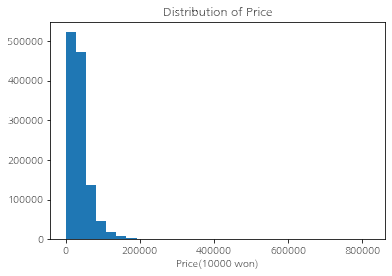

In [ ]:
# train price
plt.figure()
plt.hist(train_df['transaction_real_price'], bins=30)
plt.xlabel('Price(10000 won)')
plt.title('Distribution of Price')
plt.show()

- 가격의 분포가 매우 왼쪽으로 치우친 것을 확인할 수 있음
- 타겟 변수의 이상치가 회귀모형을 사용한 예측에 큰 영향을 줄 수 있음
    - 로그 변환으로 정규화한뒤, 나중에 다시 역변환

In [10]:
# 가격 로그 변환 후 원래 가격 따로 저장
all_df['log_price'] = np.log1p(all_df['transaction_real_price'])
real_price = all_df['transaction_real_price'] # 원래 가격
#train_y = real_price[:train_df.shape[0]] # train 데이터의 가격
#test_y = real_price[train_df.shape[0]:] # test 데이터의 가격
all_df.drop('transaction_real_price', axis=1, inplace=True)
all_df.head(1)

,transaction_id,apartment_id,city,dong,apt,exclusive_use_area,year_of_completion,transaction_year_month,floor,top10,log_price
0,0,7622,서울특별시,신교동,신현,84.82,41,0,2,0,10.532123


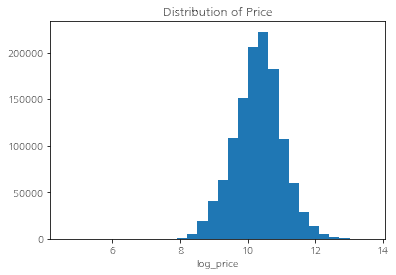

In [ ]:
# train price
plt.figure()
plt.hist(all_df['log_price'], bins=30)
plt.xlabel('log_price')
plt.title('Distribution of Price')
plt.show()

### Area

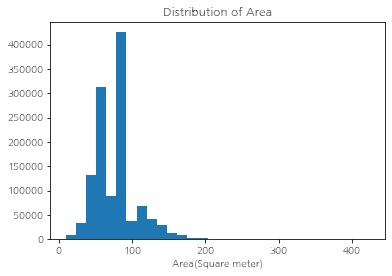

In [11]:
# train area
plt.figure()
plt.hist(train_df['exclusive_use_area'], bins=30)
plt.xlabel('Area(Square meter)')
plt.title('Distribution of Area')
plt.show()

In [12]:
# 면적 로그 변환 후 원래 면적 따로 저장
all_df['log_area'] = np.log1p(all_df['exclusive_use_area'])
area = all_df['exclusive_use_area'] # 원래 가격
all_df.drop('exclusive_use_area', axis=1, inplace=True)
all_df.head(1)

,transaction_id,apartment_id,city,dong,apt,year_of_completion,transaction_year_month,floor,top10,log_price,log_area
0,0,7622,서울특별시,신교동,신현,41,0,2,0,10.532123,4.452252


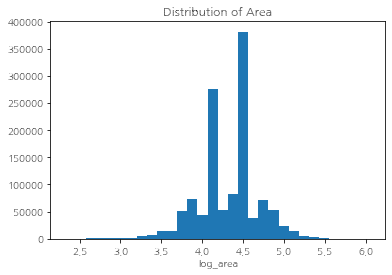

In [ ]:

plt.figure()
plt.hist(all_df['log_area'], bins=30)
plt.xlabel('log_area')
plt.title('Distribution of Area')
plt.show()

### Encoding

In [ ]:
def label_encoder(col):
    le = LabelEncoder()
    return le.fit_transform(col)
ohe_col = ['city']
drop_col = ['transaction_id', 'apartment_id', 'city', 'dong', 'apt']

ohe_columns = pd.get_dummies(all_df[ohe_col])


In [ ]:
all_df = pd.concat([all_df.drop(drop_col, axis=1), ohe_columns], axis=1)
all_df.head()

,year_of_completion,transaction_year_month,floor,top10,log_price,log_area,city_부산광역시,city_서울특별시
0,41,0,2,0,10.532123,4.452252,0,1
1,12,0,6,0,9.903538,4.606869,0,1
2,46,0,6,0,10.558439,4.451319,0,1
3,42,0,15,0,11.678448,4.993082,0,1
4,43,0,3,0,11.695255,5.275202,0,1


In [ ]:
all_df.shape

(1222016, 8)

In [ ]:
all_df.to_csv('all_df.csv', index=False)

## 전처리 생략 


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from tqdm import tqdm
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso,  Ridge, LassoLarsIC
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.model_selection import KFold, cross_val_score, train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
import re
!pip install optuna -q
import optuna

import matplotlib as mpl  # 기본 설정 만지는 용도
import matplotlib.pyplot as plt  # 그래프 그리는 용도
import matplotlib.font_manager as fm
!apt-get update -qq
!apt-get install fonts-nanum* -qq
path = '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf'  # 설치된 나눔글꼴중 원하는 녀석의 전체 경로를 가져오자
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)
fm._rebuild()
mpl.rcParams['axes.unicode_minus'] = False

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


NanumGothic Eco


In [3]:
PATH = '/content/drive/MyDrive/input/dataminingTP/'
train_df = pd.read_csv(PATH + 'train_df_regex.csv')
all_df = pd.read_csv(PATH + 'all_df.csv')

In [4]:
train_df = all_df[:train_df.shape[0]]
train_y = train_df['log_price']
train_X = train_df.drop('log_price', axis=1)
test_df = all_df[train_df.shape[0]:].drop('log_price', axis=1)
print(train_df.shape, test_df.shape, train_X.shape, train_y.shape)

(1216553, 8) (5463, 7) (1216553, 7) (1216553,)



## Modeling

### Linear Regression

In [5]:
reg = LinearRegression().fit(train_X, train_y)
reg.score(train_X, train_y) # R^2

0.7329833327398763

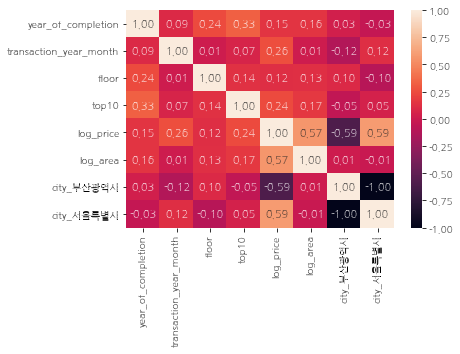

In [6]:
sns.heatmap(train_df.corr(), annot=True, fmt='.2f', annot_kws={"fontsize":11})
plt.show()

### Set RMSE Score

In [5]:
def RMSE(y, y_pred):
    rmse = mean_squared_error(y, y_pred) ** 0.5
    return rmse

def rmse_cv(model):
    tscv = TimeSeriesSplit(n_splits=10)
    rmse_list = []
    for i, (train_index, test_index) in enumerate(tscv.split(train_X), start=1):
        X_train, X_test = train_X.iloc[train_index], train_X.iloc[test_index]
        y_train, y_test = train_y.iloc[train_index], train_y.iloc[test_index]
        clf = model.fit(X_train, y_train)
        pred = clf.predict(X_test)
        rmse = RMSE(y_test, pred) 
        rmse_list.append(rmse)
    return type(model).__name__, rmse_list

def print_rmse_score(model):
    model_name, score = rmse_cv(model)
    for i, r in tqdm(enumerate(score, start=1), leave=True):
        if i == 1:
            print('\n')
            print(f'{i} FOLDS: {model_name} RMSE: {r:.4f}')
        else:
            print(f'{i} FOLDS: {model_name} RMSE: {r:.4f}')
    print(f'\n{model_name} mean RMSE: {np.mean(score):.4f}')
    print('='*40)

In [10]:
#ridge = Ridge(alpha=0.8, random_state=1)
#lasso = Lasso(alpha = 0.01, random_state=1)
#Enet = ElasticNet(alpha=0.03, l1_ratio=0.01, random_state=1)

# DTree의 스코어가 가장 높았으므로 DTree 부터 시작
DTree = DecisionTreeRegressor(max_depth=6, min_samples_split=10, min_samples_leaf=15, random_state=1)
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4,
                                   max_features='sqrt', min_samples_leaf=15, min_samples_split=10,
                                   loss='huber', random_state=1)
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, learning_rate=0.05,
                             max_depth=3, min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571, subsample=0.5213,
                             silent=1, random_state=1, nthread=-1)
model_lgb = lgb.LGBMRegressor(objective='regression', num_leaves=5, learning_rate=0.05, 
                              n_estimators=720, max_bin=55, bagging_fraction=0.8,
                              bagging_freq=5, feature_fraction=0.2319, feature_fraction_seed=9,
                              bagging_seed=9, min_data_in_leaf=6, min_sum_hessian_in_leaf=11)

In [ ]:
#for model in [ridge, lasso, Enet, DTree]:
#    print_rmse_score(model)

10it [00:00, 1772.37it/s]




1 FOLDS: Ridge RMSE: 0.2900
2 FOLDS: Ridge RMSE: 0.3195
3 FOLDS: Ridge RMSE: 0.2598
4 FOLDS: Ridge RMSE: 0.5896
5 FOLDS: Ridge RMSE: 0.6073
6 FOLDS: Ridge RMSE: 0.3746
7 FOLDS: Ridge RMSE: 0.3501
8 FOLDS: Ridge RMSE: 0.3575
9 FOLDS: Ridge RMSE: 0.3185
10 FOLDS: Ridge RMSE: 0.4028

Ridge mean RMSE: 0.3870


10it [00:00, 11676.79it/s]




1 FOLDS: Lasso RMSE: 0.2960
2 FOLDS: Lasso RMSE: 0.3244
3 FOLDS: Lasso RMSE: 0.2644
4 FOLDS: Lasso RMSE: 0.6048
5 FOLDS: Lasso RMSE: 0.6075
6 FOLDS: Lasso RMSE: 0.5447
7 FOLDS: Lasso RMSE: 0.3531
8 FOLDS: Lasso RMSE: 0.3633
9 FOLDS: Lasso RMSE: 0.3199
10 FOLDS: Lasso RMSE: 0.4007

Lasso mean RMSE: 0.4079


10it [00:00, 1885.00it/s]




1 FOLDS: ElasticNet RMSE: 0.3105
2 FOLDS: ElasticNet RMSE: 0.3251
3 FOLDS: ElasticNet RMSE: 0.2647
4 FOLDS: ElasticNet RMSE: 0.6173
5 FOLDS: ElasticNet RMSE: 0.6075
6 FOLDS: ElasticNet RMSE: 0.4888
7 FOLDS: ElasticNet RMSE: 0.3639
8 FOLDS: ElasticNet RMSE: 0.3705
9 FOLDS: ElasticNet RMSE: 0.3253
10 FOLDS: ElasticNet RMSE: 0.4020

ElasticNet mean RMSE: 0.4075


10it [00:00, 1875.64it/s]



1 FOLDS: DecisionTreeRegressor RMSE: 0.2624
2 FOLDS: DecisionTreeRegressor RMSE: 0.3234
3 FOLDS: DecisionTreeRegressor RMSE: 0.2562
4 FOLDS: DecisionTreeRegressor RMSE: 0.5516
5 FOLDS: DecisionTreeRegressor RMSE: 0.5551
6 FOLDS: DecisionTreeRegressor RMSE: 0.3847
7 FOLDS: DecisionTreeRegressor RMSE: 0.3207
8 FOLDS: DecisionTreeRegressor RMSE: 0.3126
9 FOLDS: DecisionTreeRegressor RMSE: 0.3233
10 FOLDS: DecisionTreeRegressor RMSE: 0.3936

DecisionTreeRegressor mean RMSE: 0.3683


In [11]:
for model in [DTree, model_xgb, model_lgb]:
    print_rmse_score(model)

10it [00:00, 16584.83it/s]




1 FOLDS: DecisionTreeRegressor RMSE: 0.2624
2 FOLDS: DecisionTreeRegressor RMSE: 0.3234
3 FOLDS: DecisionTreeRegressor RMSE: 0.2562
4 FOLDS: DecisionTreeRegressor RMSE: 0.5516
5 FOLDS: DecisionTreeRegressor RMSE: 0.5551
6 FOLDS: DecisionTreeRegressor RMSE: 0.3847
7 FOLDS: DecisionTreeRegressor RMSE: 0.3207
8 FOLDS: DecisionTreeRegressor RMSE: 0.3126
9 FOLDS: DecisionTreeRegressor RMSE: 0.3233
10 FOLDS: DecisionTreeRegressor RMSE: 0.3936

DecisionTreeRegressor mean RMSE: 0.3683


10it [00:00, 17339.00it/s]




1 FOLDS: XGBRegressor RMSE: 0.2485
2 FOLDS: XGBRegressor RMSE: 0.3103
3 FOLDS: XGBRegressor RMSE: 0.2326
4 FOLDS: XGBRegressor RMSE: 0.5425
5 FOLDS: XGBRegressor RMSE: 0.5298
6 FOLDS: XGBRegressor RMSE: 0.2785
7 FOLDS: XGBRegressor RMSE: 0.2859
8 FOLDS: XGBRegressor RMSE: 0.2609
9 FOLDS: XGBRegressor RMSE: 0.2737
10 FOLDS: XGBRegressor RMSE: 0.3258

XGBRegressor mean RMSE: 0.3288


10it [00:00, 1756.48it/s]



1 FOLDS: LGBMRegressor RMSE: 0.2507
2 FOLDS: LGBMRegressor RMSE: 0.3088
3 FOLDS: LGBMRegressor RMSE: 0.2475
4 FOLDS: LGBMRegressor RMSE: 0.5487
5 FOLDS: LGBMRegressor RMSE: 0.5416
6 FOLDS: LGBMRegressor RMSE: 0.3730
7 FOLDS: LGBMRegressor RMSE: 0.3537
8 FOLDS: LGBMRegressor RMSE: 0.3500
9 FOLDS: LGBMRegressor RMSE: 0.2919
10 FOLDS: LGBMRegressor RMSE: 0.3496

LGBMRegressor mean RMSE: 0.3616


- xgboost 성능이 제일 좋으나 너무 오래걸려서 lgbm 하이퍼 파라미터 튜닝 진행

### Hyperparameter Tuning

In [9]:
cut = int(len(train_df)*0.8)
h_train = train_df[:cut]
h_valid = train_df[cut:]

h_train_X = h_train.drop('log_price', axis=1)
h_train_y = h_train['log_price']
h_valid_X = h_valid.drop('log_price', axis=1)
h_valid_y = h_valid['log_price']
print(h_train_X.shape, h_train_y.shape, h_valid_X.shape, h_valid_y.shape)

(973242, 7) (973242,) (243311, 7) (243311,)


In [ ]:
 from optuna.samplers import TPESampler

 sampler = TPESampler(seed=10)
 def objective(trial):

     param = {
         'objective': 'regression', # 회귀
         'metric': 'rmse', 
         'verbosity': -1,
         'boosting_type': 'gbdt', # gradient boosting decision tree
         'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 1),
         'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 1),
         'num_leaves': trial.suggest_int('num_leaves', 2, 400),
         'max_depth': trial.suggest_int('max_depth',3, 9),
         'learning_rate': 0.01,
         'n_estimators': trial.suggest_int('n_estimators', 700, 5000),
         'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
         'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
         'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
         'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
     }

     lgbm_regr = lgb.LGBMRegressor(**param)
     gbm_2 = lgbm_regr.fit(h_train_X, h_train_y , eval_set = [(h_valid_X, h_valid_y)], verbose=False)
     rmse = RMSE(h_valid_y, gbm_2.predict(h_valid_X))
     return rmse

study = optuna.create_study(direction='minimize', sampler=sampler)
study.optimize(objective, n_trials=100)

[I 2021-06-04 09:21:07,591] A new study created in memory with name: no-name-c53ab493-a2a2-46c6-8d95-2aeaa14b8c2a
[I 2021-06-04 09:24:34,328] Trial 0 finished with value: 0.2771212520232542 and parameters: {'lambda_l1': 0.014810344004555135, 'lambda_l2': 1.4656004675652718e-08, 'num_leaves': 254, 'max_depth': 8, 'n_estimators': 2844, 'feature_fraction': 0.5348779873185086, 'bagging_fraction': 0.5188377188557745, 'bagging_freq': 6, 'min_child_samples': 21}. Best is trial 0 with value: 0.2771212520232542.
[I 2021-06-04 09:26:09,926] Trial 1 finished with value: 0.29685155243488826 and parameters: {'lambda_l1': 5.090008568091192e-08, 'lambda_l2': 0.003040034742832493, 'num_leaves': 382, 'max_depth': 3, 'n_estimators': 2902, 'feature_fraction': 0.8875725769912681, 'bagging_fraction': 0.7675156400976328, 'bagging_freq': 6, 'min_child_samples': 33}. Best is trial 0 with value: 0.2771212520232542.
[I 2021-06-04 09:27:21,525] Trial 2 finished with value: 0.2969761603138836 and parameters: {'la

In [ ]:
print('Best Trial: score {},\nparams {}'.format(study.best_trial.value, study.best_trial.params))

In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
'lambda_l1': 5.053283684347473e-08, 'lambda_l2': 1.539868437981998e-08, 'num_leaves': 511, 'n_estimators': 9729, 'feature_fraction': 0.8747648706381312, 'bagging_fraction': 0.9320244715674311, 'bagging_freq': 4, 'min_child_samples': 13}. Best is trial 76 with value: 12933.169959971665.

[I 2021-06-03 14:06:02,019] A new study created in memory with name: no-name-b310a7b3-76a2-410d-b7ba-d5cf920cd3ce
[I 2021-06-03 14:21:39,377] Trial 0 finished with value: 13802.002824527683 and parameters: {'lambda_l1': 0.08747537025773001, 'lambda_l2': 1.537331564587801e-08, 'num_leaves': 325, 'n_estimators': 7664, 'feature_fraction': 0.6991042073815543, 'bagging_fraction': 0.5348779873185086, 'bagging_freq': 2, 'min_child_samples': 78}. Best is trial 0 with value: 13802.002824527683.
[I 2021-06-03 14:39:31,506] Trial 1 finished with value: 15409.857156590153 and parameters: {'lambda_l1': 3.32657660618516e-07, 'lambda_l2': 6.238186113062485e-08, 'num_leaves': 352, 'n_estimators': 9567, 'feature_fraction': 0.4023689597967487, 'bagging_fraction': 0.707315358031466, 'bagging_freq': 6, 'min_child_samples': 63}. Best is trial 0 with value: 13802.002824527683.
[I 2021-06-03 14:55:54,488] Trial 2 finished with value: 13530.140547303346 and parameters: {'lambda_l1': 0.03131827670437561, 'lamb